In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('Advertising.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print(df.head())

      TV  radio  newspaper  sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9


## Realiza una regresión lineal simple para predecir la variable "sales" usando el resto de las variables en el dataset.

In [10]:
X = df.drop(columns=['sales'])
y = df['sales']
X_sm = sm.add_constant(X)

In [11]:
model_ols_base = sm.OLS(y, X_sm).fit()
print(model_ols_base.summary())

r2_ols_base = model_ols_base.rsquared
rmse_ols_base = np.sqrt(model_ols_base.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           1.58e-96
Time:                        16:07:28   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

## Realiza una regresión con XGBoost para predecir la variable "sales" usando el resto de las variables en el dataset (con optimización de hiperparámetros)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

In [13]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print(f"Mejores parámetros XGBoost: {grid_search.best_params_}")

y_pred_xgb = best_xgb.predict(X_test)
r2_xgb_base = r2_score(y_test, y_pred_xgb)
print(f"R2 XGBoost Base: {r2_xgb_base:.4f}")

Mejores parámetros XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
R2 XGBoost Base: 0.9851


## Comprueba los 6 problemas potenciales dentro del resultado encontrado en el punto 1. Modifica tu dataset/X de acuerdo a los resultados y justifica cualquier cambio realizado (añadir interacciones, quitar factores, agregar polinomios, quitar muestras, etc)

### No linealidad 

Text(0, 0.5, 'Residuos')

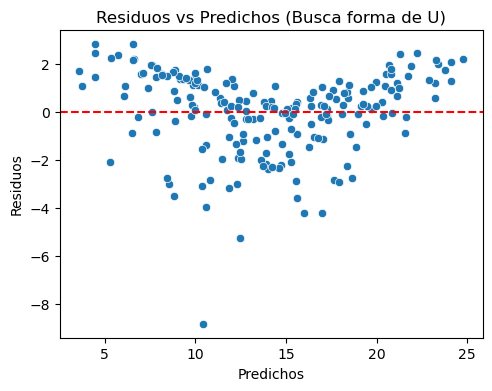

In [35]:
residuals = model_ols_base.resid
fitted = model_ols_base.predict(X_sm)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos vs Predichos (Busca forma de U)")
plt.xlabel("Predichos"); plt.ylabel("Residuos")

### Normalidad

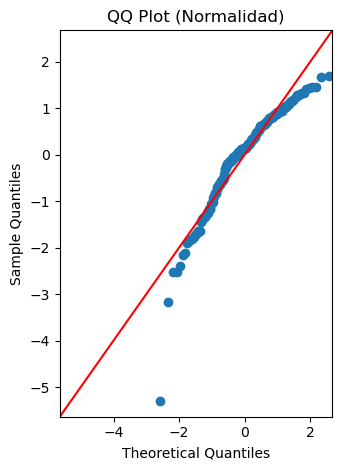

In [34]:
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title("QQ Plot (Normalidad)")
plt.tight_layout()
plt.show()

### Colinealidad

In [36]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("\nVIF (Colinealidad):\n", vif_data)


VIF (Colinealidad):
      feature       VIF
0         TV  2.486772
1      radio  3.285462
2  newspaper  3.055245


### Outliers

In [ ]:
influence = model_ols_base.get_influence()
cooks = influence.cooks_distance[0]

### Solucion a no linealidad

In [ ]:
df_refined = df.copy()

df_refined['tv_radio'] = df_refined['TV'] * df_refined['radio']

### Solucion a outliers

In [37]:
n = len(df)
threshold_cook = 4 / n
outliers_idx = np.where(cooks > threshold_cook)[0]
print(f"\nEliminando {len(outliers_idx)} outliers detectados por Distancia de Cook.")
df_refined = df_refined.drop(index=outliers_idx).reset_index(drop=True)



Eliminando 16 outliers detectados por Distancia de Cook.


### Nuevas X y 'y' definidas

In [38]:
# Nuevas variables X e y refinadas
X_refined = df_refined.drop(columns=['sales'])
y_refined = df_refined['sales']

## Realiza el punto 1 con el dataset/X resultante del punto 3.

In [40]:
X_refined_sm = sm.add_constant(X_refined)
model_ols_refined = sm.OLS(y_refined, X_refined_sm).fit()
print(model_ols_refined.summary())
r2_ols_refined = model_ols_refined.rsquared

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1873.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):          4.58e-135
Time:                        16:23:47   Log-Likelihood:                -187.54
No. Observations:                 168   AIC:                             385.1
Df Residuals:                     163   BIC:                             400.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2649      0.222     28.209      0.0

## Realiza el punto 2 con el dataset/X resultante del punto 3.

In [42]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_refined, y_refined, test_size=0.2, random_state=42)

best_xgb.fit(X_train_r, y_train_r) # Reentrenamos el mejor modelo
y_pred_xgb_r = best_xgb.predict(X_test_r)
r2_xgb_refined = r2_score(y_test_r, y_pred_xgb_r)
print(f"R2 XGBoost: {r2_xgb_refined:.4f}")


R2 XGBoost: 0.9878


## Compara resultados entre puntos 1&4 y 2&5. ¿Qué observas?

In [43]:
resumen = pd.DataFrame({
    'Modelo': ['Regresión Base', 'XGBoost Base', 'Regresión Refinada', 'XGBoost Refinado'],
    'R2': [r2_ols_base, r2_xgb_base, r2_ols_refined, r2_xgb_refined]
})
print(resumen)

               Modelo        R2
0      Regresión Base  0.897211
1        XGBoost Base  0.985130
2  Regresión Refinada  0.978705
3    XGBoost Refinado  0.987833


## Optimiza tu R2 agregando transformaciones al dataset. El modelo con mejor calificación tiene 10 garantizado en el examen.

In [44]:
X_for_poly = df_refined.drop(columns=['sales', 'tv_radio']) 

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_for_poly)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y_refined, test_size=0.2, random_state=42)

final_model = LinearRegression()
final_model.fit(X_train_p, y_train_p)
y_pred_final = final_model.predict(X_test_p)
r2_final = r2_score(y_test_p, y_pred_final)

print(f"R2 Polinomios : {r2_final:.4f}")

R2 Polinomios : 0.9898
